In [1]:
path_full_summarized_table = "../results/2023-05-24/00_processed/main/aurocs.tsv.gz"

path_config_viz = "../config/visualization.yaml"
path_output_dir = "./input_modalities.rnaprot_extended_vs_seqonly/"
export = True


# Forewords

2023-06-08: our January batch for RNAProt "extended" was actually a sequence-only set of models,
due to the training and evaluation scripts completing successfully even if additional features could not be read.

After correction and verification of the correctness of input features, we got true "RNAProt-extended" models (named "RNAProt"),
which outperformed all other single-label models.

Given the large jump in performance, we explicitely investigate here the difference between RNAProt (May batch, seq+cons+exonIntron)
and "RNAProt-seqonly" (January batch).

# Imports and definitions

In [2]:
import os
import sys
from pathlib import Path

import pandas as pd
import polars as pl
import numpy as np
import yaml


path = "../code/"
if not str(path) in sys.path:
    sys.path.insert(0, str(path))

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from plotting_config import *

%run "../code/plotting_config.py"
%run "../code/figure_layouts.py"

/home/l10n/projects/hzm/Benchmark-RBP/analyses/code/figure_layouts.py:99: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


# Set-up

In [3]:
if export:
    if not Path(path_output_dir).exists():
        Path(path_output_dir).mkdir(parents=True, exist_ok=True)

# Load

## Data

In [4]:
full_summarized_table = pd.read_csv(
    path_full_summarized_table, sep="\t", header=0, index_col=None
)


## Config

In [5]:
with open(path_config_viz, "r") as in_f:
    config_viz = yaml.load(in_f, Loader=yaml.SafeLoader)


DATASETS_COLORS = config_viz["datasets"]["colors"]
DATASETS_dotshape = config_viz["datasets"]["shape"]
arch_colors = config_viz["methods"]["colors"]

# Prepare tables

In [6]:
# This table is used for the boxplot per dataset and the scatterplot.
tmp = (
    full_summarized_table.loc[lambda df: (df["arch"].str.startswith("RNAProt")) , :]
    .pivot_table(
        columns="arch",
        index=["dataset", "RBP_dataset","model_negativeset"],
        values="auroc",
    )
    .reset_index()
)

tmp["delta"] = (
    tmp["RNAProt-seqonly"] - tmp["RNAProt"]
)


In [7]:
tmp_rnaprot_n1 = full_summarized_table.loc[
    lambda df: (df["model_negativeset"] == "negative-1")
    & (df["arch"].isin(["RNAProt", "RNAProt-seqonly"])),
    :,
]

tmp_rnaprot_n2 = full_summarized_table.loc[
    lambda df: (df["model_negativeset"] == "negative-2")
    & (df["arch"].isin(["RNAProt", "RNAProt-seqonly"])),
    :,
]


In [22]:
v1 = tmp_rnaprot_n1.loc[lambda df: df['arch'] == 'RNAProt', 'auroc'].mean()
v2 = tmp_rnaprot_n1.loc[lambda df: df['arch'] == 'RNAProt-seqonly', 'auroc'].mean()

v3 = tmp_rnaprot_n2.loc[lambda df: df['arch'] == 'RNAProt', 'auroc'].mean()
v4 = tmp_rnaprot_n2.loc[lambda df: df['arch'] == 'RNAProt-seqonly', 'auroc'].mean()

In [24]:
print(v1)
print(v2)
print(v3)
print(v4)

print()

print(v2-v1)
print(v4-v3)

0.9418791634558058
0.8857141977560022
0.8568642001156718
0.811153022542805

-0.05616496569980356
-0.0457111775728668


# Plot

## Scatterplot auROCs RNAProt-seqonly = f(RNAProt)

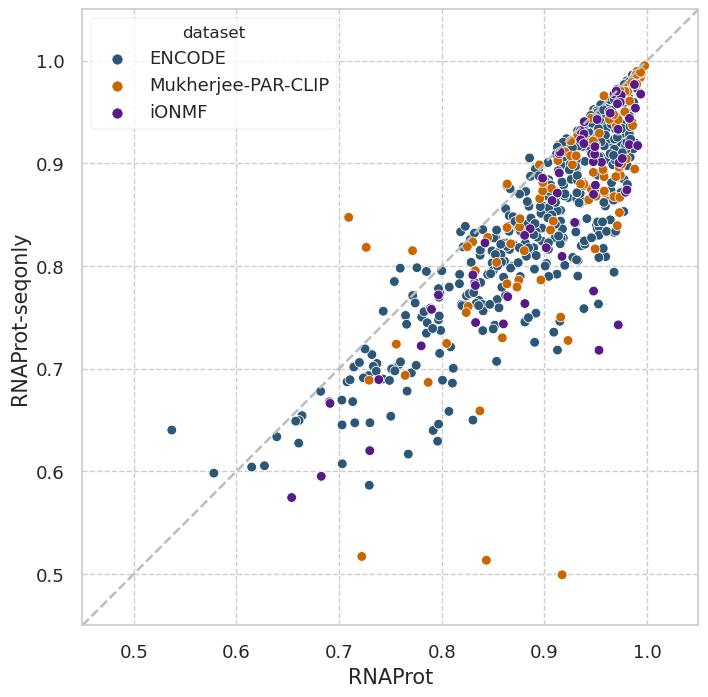

In [11]:
fig = plt.figure(
    figsize=(
        8,
        8,
    )
)
ax1 = fig.add_subplot(1, 1, 1)

sns.scatterplot(
    data=tmp,
    x="RNAProt",
    y="RNAProt-seqonly",
    hue="dataset",
    palette=DATASETS_COLORS,
    # style='dataset',
    # marker=DATASETS_dotshape,
    ax=ax1,
)

ax1.set_aspect("equal")

ax1.set_xlim(0.45, 1.05)
ax1.set_ylim(0.45, 1.05)

# Diagonal
ax1.plot((0.45, 1.05), (0.45, 1.05), linestyle="--", color="#BBBBBB")

plt.show()


## Boxplot delta auROC per dataset

In [8]:
def plot_deltaauroc(tmp_rnaprot, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(3, 8))
        ax1 = fig.add_subplot(1, 1, 1)
    else:
        ax1 = ax

    ax1.axhline(
        y=tmp_rnaprot["delta"].mean(),
        linestyle="--",
        linewidth=4,
        color="#C84244",
        label="Average",
    )

    ax1.text(
        x=-0.55,
        y=tmp_rnaprot["delta"].mean(),
        s=f"{tmp_rnaprot['delta'].mean():.2}",
        color="#C84244",
        fontsize=12,
        fontweight="bold",
        ha="right",
    )

    ax1.set_ylim(
        -tmp_rnaprot["delta"].abs().max() * 1.1,
        tmp_rnaprot["delta"].abs().max() * 1.1,
    )

    for DATASET, tmp_rnaprot_dataset in tmp_rnaprot.groupby("dataset"):
        sns.stripplot(
            data=tmp_rnaprot_dataset,
            x="dataset",
            y="delta",
            hue="dataset",
            palette=DATASETS_COLORS,
            # style='dataset',
            marker=DATASETS_dotshape[DATASET],
            edgecolor="#FFFFFF",
            linewidth=1,
            size=10,
            zorder=0,
            alpha=0.5,
            ax=ax1,
        )

    # Add boxplot without face colors.
    BOXPLOT_PROPS = {
        "boxprops": {"facecolor": "none", "edgecolor": "#444444"},
        "medianprops": {"color": "#444444"},
        "whiskerprops": {"color": "#444444"},
        "capprops": {"color": "#444444"},
        "meanprops": {
            "marker": "o",
            "markerfacecolor": "#AF2121",
            "markeredgecolor": "#AF2121",
            "markersize": 8,
        },
    }

    sns.boxplot(
        data=tmp_rnaprot,
        x="dataset",
        y="delta",
        showfliers=False,
        showmeans=True,
        linewidth=2,
        ax=ax1,
        zorder=10,
        **BOXPLOT_PROPS,
    )

    ax1.legend_.set_title("")
    ax1.set_xticklabels("")
    ax1.set_xlabel("Datasets", fontsize=14)
    ax1.set_ylabel("Delta auROC (RNAProt - RNAProt-seqonly)", fontsize=14)

    plt.tight_layout()

    return ax1


Saving


<Figure size 775.974x775.974 with 0 Axes>

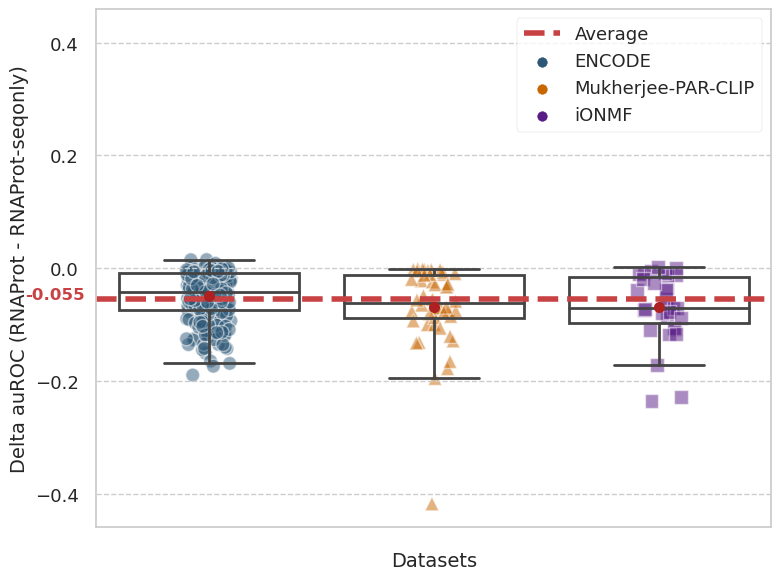

In [10]:


figure_name = "delta_aurocs_rnaprot_rnaprot-seqonly"

if export:
    savefig_file = str(Path(path_output_dir) / f"{figure_name}.{{EXT}}")
else:
    savefig_file = None

panel_name = "c"
fig = plt.figure(figsize=[v * 5 for v in FIG3_PANEL_SIZES["i"]])
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(1, 1, 1)

plot_deltaauroc(tmp, ax=ax1)

if savefig_file:
    print("Saving")
    my_savefig(savefig_file, ext_list=["png", "svg", "pdf"])

plt.show()


## Paper

negative-1 b input_modalities.rnaprot_extended_vs_seqonly/boxplot_aurocs_rnaprot_rnaprot-seqonly.negative-1.{EXT}


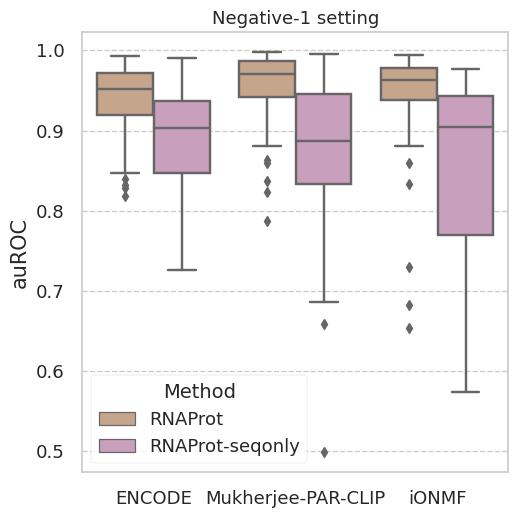

negative-2 c input_modalities.rnaprot_extended_vs_seqonly/boxplot_aurocs_rnaprot_rnaprot-seqonly.negative-2.{EXT}


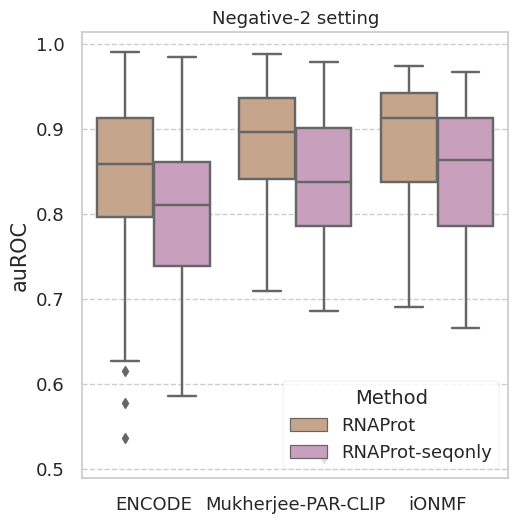

In [8]:

groups = zip(
    ["negative-1", "negative-2"],
    ["b", "c"],
    [tmp_rnaprot_n1, tmp_rnaprot_n2],
)

for NEGATIVE, panel_name, tmp_table in groups:
    
    figure_name = f"boxplot_aurocs_rnaprot_rnaprot-seqonly.{NEGATIVE}"

    if export:
        savefig_file = str(Path(path_output_dir) / f"{figure_name}.{{EXT}}")
    else:
        savefig_file = None

    print(NEGATIVE, panel_name, savefig_file)

    fig = plt.figure(figsize=[v * 3.5 for v in FIG3_PANEL_SIZES[panel_name]])
    ax1 = fig.add_subplot(1, 1, 1)

    sns.boxplot(
        data=tmp_table,
        y="auroc",
        x="dataset",
        hue="arch",
        palette=arch_colors,
        hue_order=["RNAProt", "RNAProt-seqonly"],
        ax=ax1,
    )

    ax1.set_xlabel("")
    ax1.legend_.set_title("Method")
    plt.setp(ax1.legend_.get_title(), fontsize=14)

    ax1.set_ylabel("auROC")
    ax1.set_title(f"{NEGATIVE.capitalize()} setting")

    fig.subplots_adjust(left=0.10)

    plt.tight_layout()

    if export:
        my_savefig(savefig_file, ext_list=["png", "svg", "pdf"])

    plt.show()
